## Model Tuning and Validation

In order to test different models, I will be using sklearn's GridSearchCV package with the default 5-fold cross validation.

In [1]:
# Import resources
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, f1_score, plot_roc_curve, plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
# Read in the data sets from main notebook
X_train = pd.read_csv("data/X_train.csv").set_index('Unnamed: 0')
X_test = pd.read_csv("data/X_test.csv").set_index('Unnamed: 0')
y_train = pd.read_csv("data/y_train.csv").set_index('Unnamed: 0')
y_test = pd.read_csv("data/y_test.csv").set_index('Unnamed: 0')

## Generate Preprocessed Array for Grid Searching

In [3]:
# Data preprocessing column transformer
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(
    steps=[("num_imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(
    steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown = 'ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [4]:
# Generate preprocessed data
preproc = Pipeline(
    steps=[("preprocessor", preprocessor)]
)

X_train_proc = preproc.fit_transform(X_train)
X_test_proc = preproc.transform(X_test)

In [5]:
X_train_proc.shape

(20000, 67)

## Logistic Regression

0.5711
{'logistic__C': 1000, 'logistic__fit_intercept': True, 'logistic__max_iter': 1000, 'logistic__n_jobs': 4, 'logistic__random_state': 27, 'logistic__solver': 'sag'}
Test recall 0.580952380952381


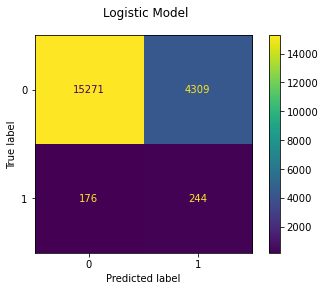

In [6]:
logpipe = Pipeline([
    ('logistic', LogisticRegression())
])

# Parameters for the grid search
parameters = {
    'logistic__C': [1000], # Tried: 1, 10, 100, 1000, 10,000
    'logistic__max_iter': [1000],
    'logistic__fit_intercept': [True], # Tried: False
    'logistic__random_state': [27],
    'logistic__solver': ['sag'], # Tried: saga, lbfgs
    'logistic__n_jobs': [4]
}

# Perform grid search
grid_log = GridSearchCV(logpipe, param_grid=parameters, scoring='recall')

# Fit grid search and predict
grid_log.fit(X_train_proc, y_train.values.ravel())

print(grid_log.best_score_)
print(grid_log.best_params_)

# Confusion matrix for the logistic model
fig, ax = plt.subplots()

fig.suptitle("Logistic Model")

plot_confusion_matrix(grid_log, X_test_proc, y_test, ax=ax, values_format='');

print("Test recall", recall_score(y_test, grid_log.predict(X_test_proc)))

## KNNeighbors Classifier

0.5322000000000001
{'knn__leaf_size': 10, 'knn__n_jobs': 4, 'knn__n_neighbors': 5}
Test recall 0.5214285714285715


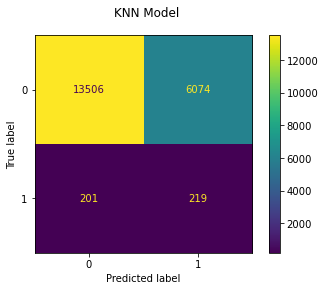

In [7]:
knnpipe = Pipeline([
    ('knn', KNeighborsClassifier())
])

# Parameters for the grid search
parameters = {
    'knn__n_neighbors': [5], # Tried: 2-10
    'knn__leaf_size': [10], # Tried: 5-100
    'knn__n_jobs': [4]
}

# Perform grid search
grid_knn = GridSearchCV(knnpipe, param_grid=parameters, scoring='recall')

# Fit grid search and predict
grid_knn.fit(X_train_proc, y_train.values.ravel())

print(grid_knn.best_score_)
print(grid_knn.best_params_)

# Confusion matrix for the KNN model
fig, ax = plt.subplots()

fig.suptitle("KNN Model")

plot_confusion_matrix(grid_knn, X_test_proc, y_test, ax=ax, values_format='');

print("Test recall", recall_score(y_test, grid_knn.predict(X_test_proc)))

## Decision Tree Classifier

0.6045999999999999
{'tree__criterion': 'gini', 'tree__max_depth': 30, 'tree__min_samples_leaf': 30, 'tree__min_samples_split': 2, 'tree__random_state': 27}
Test recall 0.6238095238095238


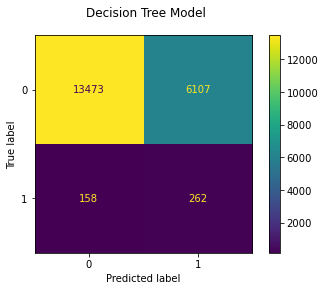

In [8]:
treepipe = Pipeline([
    ('tree', DecisionTreeClassifier())
])

# Parameters for the grid search
parameters = {
    'tree__criterion': ['gini'], # Tried: entropy
    'tree__max_depth': [30], # Tried: 2-40
    'tree__min_samples_split': [2], # Tried: 2-50
    'tree__min_samples_leaf': [30], # Tried: 2-300
    'tree__random_state': [27]
}

# Perform grid search
grid_tree = GridSearchCV(treepipe, param_grid=parameters, scoring='recall')

# Fit grid search and predict
grid_tree.fit(X_train_proc, y_train.values.ravel())

print(grid_tree.best_score_)
print(grid_tree.best_params_)

# Confusion matrix for the Tree model
fig, ax = plt.subplots()

fig.suptitle("Decision Tree Model")

plot_confusion_matrix(grid_tree, X_test_proc, y_test, ax=ax, values_format='');

print("Test recall", recall_score(y_test, grid_tree.predict(X_test_proc)))

## Random Forest

0.5996
{'forest__criterion': 'gini', 'forest__max_depth': 50, 'forest__min_samples_leaf': 2, 'forest__min_samples_split': 10, 'forest__n_estimators': 5, 'forest__n_jobs': 4, 'forest__random_state': 27}
Test recall 0.6166666666666667


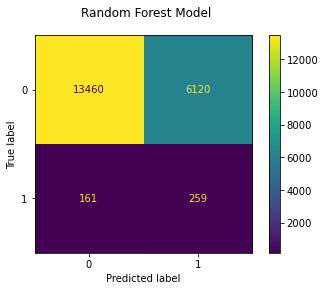

In [9]:
forestpipe = Pipeline([
    ('forest', RandomForestClassifier())
])

# Parameters for the grid search
parameters = {
    'forest__n_estimators': [5], # Tried: 2-300
    'forest__criterion': ['gini'], # Tried: entropy
    'forest__min_samples_split': [10], # Tried: 2-20
    'forest__min_samples_leaf': [2], # Tried: 2-50
    'forest__max_depth': [50], # Tried: 2-60
    'forest__n_jobs': [4],
    'forest__random_state': [27]
}

# Perform grid search
grid_forest = GridSearchCV(forestpipe, param_grid=parameters, scoring='recall')

# Fit grid search and predict
grid_forest.fit(X_train_proc, y_train.values.ravel())

print(grid_forest.best_score_)
print(grid_forest.best_params_)

# Confusion matrix for the Forest model
fig, ax = plt.subplots()

fig.suptitle("Random Forest Model")

plot_confusion_matrix(grid_forest, X_test_proc, y_test, ax=ax, values_format='');

print("Test recall", recall_score(y_test, grid_forest.predict(X_test_proc)))

## XGBoost

0.6131
{'boost__gamma': 1, 'boost__max_depth': 19, 'boost__min_child_weight': 27, 'boost__n_estimators': 125, 'boost__random_state': 27}
Test recall 0.65


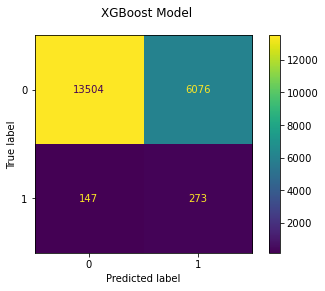

In [10]:
boostpipe = Pipeline([
    ('boost', xgboost.XGBClassifier())
])

# Parameters for grid search
parameters = {
    'boost__max_depth': [19], # Tried: 2-50
    'boost__min_child_weight': [27], # Tried: 1-50
    'boost__gamma': [1], # Tried: 0.5-200
    'boost__n_estimators': [125], # Tried: 5-75
    'boost__random_state': [27]
}

# Grid search with xgboost model
grid_boost = GridSearchCV(boostpipe, param_grid=parameters, scoring='recall')

# Fit model and generate predictions
grid_boost.fit(X_train_proc, y_train.values.ravel())

print(grid_boost.best_score_)
print(grid_boost.best_params_)

# Confusion matrix for the XGBoost model
fig, ax = plt.subplots()

fig.suptitle("XGBoost Model")

plot_confusion_matrix(grid_boost, X_test_proc, y_test, ax=ax, values_format='');

print("Test recall", recall_score(y_test, grid_boost.predict(X_test_proc)))

## AdaBoost

0.7458
{'ada__learning_rate': 2, 'ada__n_estimators': 30, 'ada__random_state': 27}
Test recall 0.34285714285714286


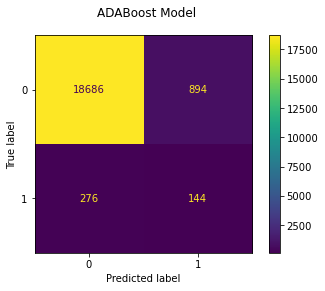

In [11]:
adapipe = Pipeline([
    ('ada', AdaBoostClassifier())
])

# Parameters for grid search
parameters = {
    'ada__n_estimators': [30], # Tried: 2-50
    'ada__learning_rate': [2], # Tried: 0.5-5
    'ada__random_state': [27]
}

# Grid search with adaboost model
grid_ada = GridSearchCV(adapipe, param_grid=parameters, scoring='recall')

# Fit model and generate predictions
grid_ada.fit(X_train_proc, y_train.values.ravel())

print(grid_ada.best_score_)
print(grid_ada.best_params_)

# Confusion matrix for the XGBoost model
fig, ax = plt.subplots()

fig.suptitle("AdaBoost Model")

plot_confusion_matrix(grid_ada, X_test_proc, y_test, ax=ax, values_format='');

print("Test recall", recall_score(y_test, grid_ada.predict(X_test_proc)))

## Multi-layer Perceptron 

0.5850000000000001
{'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': 100, 'mlp__max_iter': 500, 'mlp__random_state': 27}
Test recall 0.5119047619047619


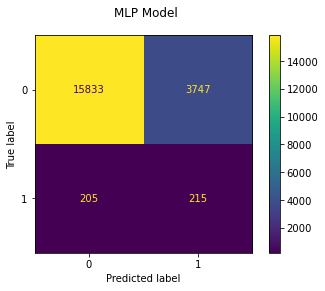

In [12]:
mlppipe = Pipeline([
    ('mlp', MLPClassifier())
])

# Parameters for grid search
parameters = {
    'mlp__hidden_layer_sizes': [100], # Tried: 50-200
    'mlp__activation': ['relu'], # Tried: logistic
    'mlp__alpha': [0.001], # Tried: 0.0001
    'mlp__max_iter': [500],
    'mlp__random_state': [27],
}

# Grid search with MLP model
grid_mlp = GridSearchCV(mlppipe, param_grid=parameters, scoring='recall')

# Fit model and generate predictions
grid_mlp.fit(X_train_proc, y_train.values.ravel())

print(grid_mlp.best_score_)
print(grid_mlp.best_params_)

# Confusion matrix for the MLP model
fig, ax = plt.subplots()

fig.suptitle("MLP Model")

plot_confusion_matrix(grid_mlp, X_test_proc, y_test, ax=ax, values_format='');

print("Test recall", recall_score(y_test, grid_mlp.predict(X_test_proc)))

## Summary

I believe the appropriate model to finalize would be the XGBoost model, which sported a 65% recall score on the test data. AdaBoost was much more effective at labeling the true negatives (predicting healthy babies will be healthy) but significantly worse than the other top contenders at true positives (predicting unhealthy babies will be unhealthy). The Decision tree classifier performed similarly well to the XGBoost model, but was slightly worse at predicting negative cases.

In order to further optimize the models, one avenue of interest could be designing a custom scoring function that strikes a better balance between the class of interest and the majority class rather than optimizing for just recall.